In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Derivative of ReLU activation function
def relu_derivative(x):
    return (x > 0).astype(float)

# Softmax function with numerical stability
def softmax(x):
    shift_x = x - np.max(x, axis=1, keepdims=True)  # Subtract max for stability
    exp_x = np.exp(shift_x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Cross-entropy loss function with stability (prevents log(0))
def cross_entropy_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred = np.clip(y_pred, a_min=1e-10, a_max=None)  # Clip values to avoid log(0)
    correct_confidences = y_pred[range(n_samples), y_true]
    loss = -np.sum(np.log(correct_confidences)) / n_samples
    return loss

# Function to compute accuracy
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Backpropagation and weight update with gradient clipping
def backprop(X, y, W1, b1, W2, b2, W3, b3, learning_rate, clip_value=5.0):
    # Forward propagation
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)  # ReLU activation

    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)  # ReLU activation

    z3 = np.dot(a2, W3) + b3
    output = softmax(z3)  # Softmax activation

    # Calculate loss
    loss = cross_entropy_loss(y, output)

    # Backward propagation
    m = y.shape[0]
    output[range(m), y] -= 1
    output /= m

    dW3 = np.dot(a2.T, output)
    db3 = np.sum(output, axis=0, keepdims=True)

    da2 = np.dot(output, W3.T)
    dz2 = da2 * relu_derivative(z2)  # ReLU derivative

    dW2 = np.dot(a1.T, dz2)
    db2 = np.sum(dz2, axis=0, keepdims=True)

    da1 = np.dot(dz2, W2.T)
    dz1 = da1 * relu_derivative(z1)  # ReLU derivative

    dW1 = np.dot(X.T, dz1)
    db1 = np.sum(dz1, axis=0, keepdims=True)

    # Gradient clipping to avoid exploding gradients
    dW1 = np.clip(dW1, -clip_value, clip_value)
    dW2 = np.clip(dW2, -clip_value, clip_value)
    dW3 = np.clip(dW3, -clip_value, clip_value)
    db1 = np.clip(db1, -clip_value, clip_value)
    db2 = np.clip(db2, -clip_value, clip_value)
    db3 = np.clip(db3, -clip_value, clip_value)

    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3

    return W1, b1, W2, b2, W3, b3, loss

# Train the neural network
def train_neural_network(X_train, y_train, X_test, y_test, learning_rate, epochs):
    input_size = X_train.shape[1]
    hidden_size1 = 100
    hidden_size2 = 40
    output_size = 4  # Number of classes

    # Initialize weights and biases with small random values
    np.random.seed(42)
    W1 = np.random.randn(input_size, hidden_size1) * 0.01
    b1 = np.zeros((1, hidden_size1))
    W2 = np.random.randn(hidden_size1, hidden_size2) * 0.01
    b2 = np.zeros((1, hidden_size2))
    W3 = np.random.randn(hidden_size2, output_size) * 0.01
    b3 = np.zeros((1, output_size))

    train_costs = []
    test_costs = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        # Backpropagation and weight updates
        W1, b1, W2, b2, W3, b3, train_loss = backprop(X_train, y_train, W1, b1, W2, b2, W3, b3, learning_rate)

        # Forward pass for training accuracy
        z1 = np.dot(X_train, W1) + b1
        a1 = relu(z1)  # ReLU activation
        z2 = np.dot(a1, W2) + b2
        a2 = relu(z2)  # ReLU activation
        z3 = np.dot(a2, W3) + b3
        train_output = softmax(z3)
        y_train_pred = np.argmax(train_output, axis=1)
        train_acc = accuracy(y_train, y_train_pred)

        # Forward pass for test accuracy
        z1_test = np.dot(X_test, W1) + b1
        a1_test = relu(z1_test)  # ReLU activation
        z2_test = np.dot(a1_test, W2) + b2
        a2_test = relu(z2_test)  # ReLU activation
        z3_test = np.dot(a2_test, W3) + b3
        test_output = softmax(z3_test)
        y_test_pred = np.argmax(test_output, axis=1)
        test_acc = accuracy(y_test, y_test_pred)

        # Calculate test loss
        test_loss = cross_entropy_loss(y_test, test_output)

        # Store loss and accuracy values
        train_costs.append(train_loss)
        test_costs.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

    return train_costs, test_costs, train_accs, test_accs

# Plot training results
def plot_metrics(train_costs, test_costs, train_accs, test_accs, learning_rate):
    epochs = len(train_costs)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_costs, label='Train Loss')
    plt.plot(range(epochs), test_costs, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss vs Epochs (Learning Rate = {learning_rate})')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accs, label='Train Accuracy')
    plt.plot(range(epochs), test_accs, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Epochs (Learning Rate = {learning_rate})')
    plt.legend()

    plt.tight_layout()
    plt.show()



X_train = pd.read_csv(r"Task_2\x_train.csv").values  # features
y_train = pd.read_csv(r"Task_2\y_train.csv").values  # labels

X_test = pd.read_csv(r"Task_2\x_test.csv").values
y_test = pd.read_csv(r"Task_2\y_test.csv").values


learning_rates = [1, 0.1, 0.001]
epochs = 50

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    train_costs, test_costs, train_accs, test_accs = train_neural_network(X_train, y_train, X_test, y_test, lr, epochs)
    plot_metrics(train_costs, test_costs, train_accs, test_accs, lr)



Training with learning rate: 1


KeyboardInterrupt: 

Training with learning rate 1
Epoch 10 | Train Loss: 1.3768 | Test Loss: 1.3767 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 20 | Train Loss: 1.3768 | Test Loss: 1.3767 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 30 | Train Loss: 1.3768 | Test Loss: 1.3767 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 40 | Train Loss: 1.3767 | Test Loss: 1.3767 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 50 | Train Loss: 1.3767 | Test Loss: 1.3767 | Train Acc: 0.0000 | Test Acc: 0.2888


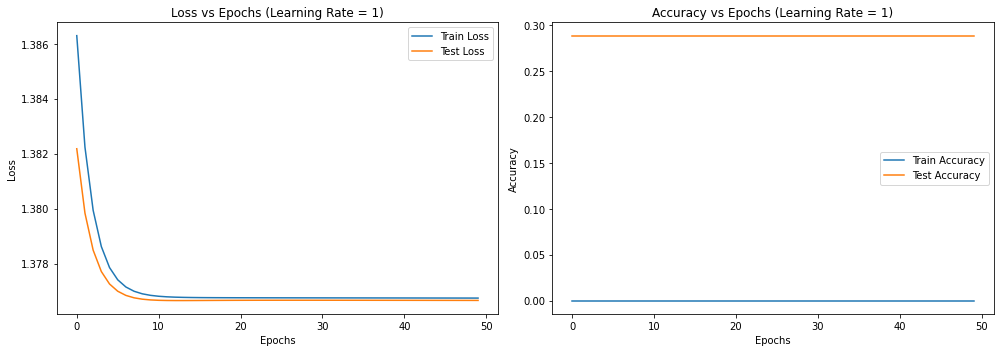

Training with learning rate 0.1
Epoch 10 | Train Loss: 1.3829 | Test Loss: 1.3826 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 20 | Train Loss: 1.3805 | Test Loss: 1.3803 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 30 | Train Loss: 1.3791 | Test Loss: 1.3789 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 40 | Train Loss: 1.3782 | Test Loss: 1.3780 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 50 | Train Loss: 1.3777 | Test Loss: 1.3775 | Train Acc: 0.0000 | Test Acc: 0.2888


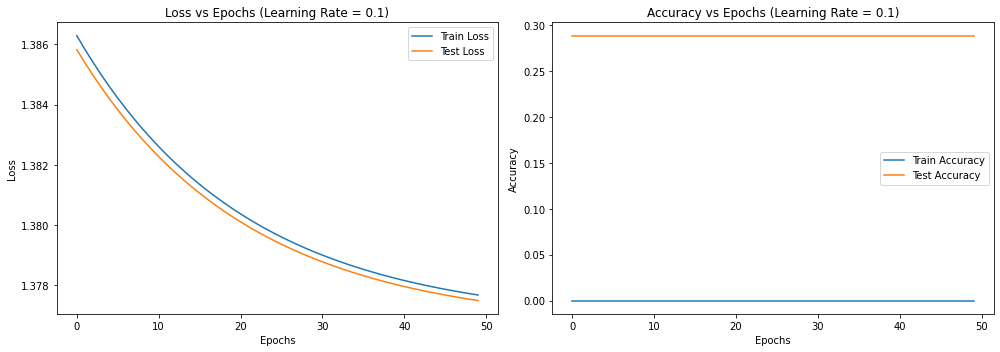

Training with learning rate 0.001
Epoch 10 | Train Loss: 1.3863 | Test Loss: 1.3862 | Train Acc: 0.0000 | Test Acc: 0.2897
Epoch 20 | Train Loss: 1.3862 | Test Loss: 1.3862 | Train Acc: 0.0000 | Test Acc: 0.2885
Epoch 30 | Train Loss: 1.3862 | Test Loss: 1.3862 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 40 | Train Loss: 1.3861 | Test Loss: 1.3861 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 50 | Train Loss: 1.3861 | Test Loss: 1.3861 | Train Acc: 0.0000 | Test Acc: 0.2888


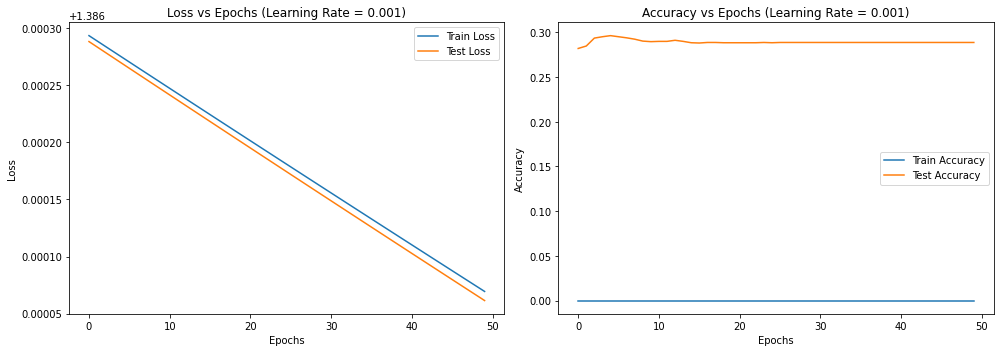

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Derivative of ReLU activation function
def relu_derivative(x):
    return (x > 0).astype(float)

# Softmax function with numerical stability
def softmax(x):
    shift_x = x - np.max(x, axis=1, keepdims=True)  # Subtract max for stability
    exp_x = np.exp(shift_x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Cross-entropy loss function with one-hot encoded labels and softmax output
def cross_entropy_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred = np.clip(y_pred, a_min=1e-10, a_max=None)  # Clip values to avoid log(0)
    loss = -np.sum(y_true * np.log(y_pred)) / n_samples
    return loss

# Function to compute accuracy
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == y_pred)

# One-hot encoding function
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y.reshape(-1)]

# Backpropagation and weight update with gradient clipping
def backprop(X, y, z1, a1, z2, a2, z3, output, W1, b1, W2, b2, W3, b3, learning_rate, clip_value=5.0):
    m = y.shape[0]
    output -= y  # Output is softmax - y_true for cross-entropy derivative
    output /= m

    dW3 = np.dot(a2.T, output)
    db3 = np.sum(output, axis=0, keepdims=True)

    da2 = np.dot(output, W3.T)
    dz2 = da2 * relu_derivative(z2)  # ReLU derivative

    dW2 = np.dot(a1.T, dz2)
    db2 = np.sum(dz2, axis=0, keepdims=True)

    da1 = np.dot(dz2, W2.T)
    dz1 = da1 * relu_derivative(z1)  # ReLU derivative

    dW1 = np.dot(X.T, dz1)
    db1 = np.sum(dz1, axis=0, keepdims=True)

    # Gradient clipping to avoid exploding gradients
    dW1 = np.clip(dW1, -clip_value, clip_value)
    dW2 = np.clip(dW2, -clip_value, clip_value)
    dW3 = np.clip(dW3, -clip_value, clip_value)
    db1 = np.clip(db1, -clip_value, clip_value)
    db2 = np.clip(db2, -clip_value, clip_value)
    db3 = np.clip(db3, -clip_value, clip_value)

    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3

    return W1, b1, W2, b2, W3, b3

# Forward propagation function
def forward_propagation(X, W1, b1, W2, b2, W3, b3):
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)  # ReLU activation

    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)  # ReLU activation

    z3 = np.dot(a2, W3) + b3
    output = softmax(z3)  # Softmax activation

    return z1, a1, z2, a2, z3, output

# Train the neural network
def train_neural_network(X_train, y_train, X_test, y_test, learning_rate, epochs, num_classes):
    input_size = X_train.shape[1]
    hidden_size1 = 100
    hidden_size2 = 40
    output_size = num_classes  # Number of classes

    # Initialize weights and biases with small random values
    np.random.seed(42)
    W1 = np.random.randn(input_size, hidden_size1) * 0.01
    b1 = np.zeros((1, hidden_size1))
    W2 = np.random.randn(hidden_size1, hidden_size2) * 0.01
    b2 = np.zeros((1, hidden_size2))
    W3 = np.random.randn(hidden_size2, output_size) * 0.01
    b3 = np.zeros((1, output_size))

    train_costs = []
    test_costs = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        # Forward propagation on training data
        z1, a1, z2, a2, z3, train_output = forward_propagation(X_train, W1, b1, W2, b2, W3, b3)

        # Calculate loss for training data
        train_loss = cross_entropy_loss(y_train, train_output)

        # Backpropagation and weight updates
        W1, b1, W2, b2, W3, b3 = backprop(X_train, y_train, z1, a1, z2, a2, z3, train_output, W1, b1, W2, b2, W3, b3, learning_rate)

        # Forward propagation on test data
        z1_test, a1_test, z2_test, a2_test, z3_test, test_output = forward_propagation(X_test, W1, b1, W2, b2, W3, b3)

        # Calculate loss and accuracy for test data
        test_loss = cross_entropy_loss(y_test, test_output)
        train_acc = accuracy(y_train, np.argmax(train_output, axis=1))
        test_acc = accuracy(y_test, np.argmax(test_output, axis=1))

        # Store loss and accuracy values
        train_costs.append(train_loss)
        test_costs.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

    return train_costs, test_costs, train_accs, test_accs

# Plot training results
def plot_metrics(train_costs, test_costs, train_accs, test_accs, learning_rate):
    epochs = len(train_costs)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_costs, label='Train Loss')
    plt.plot(range(epochs), test_costs, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss vs Epochs (Learning Rate = {learning_rate})')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accs, label='Train Accuracy')
    plt.plot(range(epochs), test_accs, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Epochs (Learning Rate = {learning_rate})')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Loading the data and performing one-hot encoding for labels
X_train = pd.read_csv(r"Task_2\x_train.csv").values  # features
y_train_raw = pd.read_csv(r"Task_2\y_train.csv").values  # raw labels

X_test = pd.read_csv(r"Task_2\x_test.csv").values
y_test_raw = pd.read_csv(r"Task_2\y_test.csv").values

# One-hot encode the labels
num_classes = 4  # Adjust based on your data
y_train = one_hot_encode(y_train_raw, num_classes)
y_test = one_hot_encode(y_test_raw, num_classes)

# Define learning rates and number of epochs
learning_rates = [1, 0.1, 0.001]
epochs = 50

for lr in learning_rates:
    print(f"Training with learning rate {lr}")
    train_costs, test_costs, train_accs, test_accs = train_neural_network(X_train, y_train, X_test, y_test, lr, epochs, num_classes)
    plot_metrics(train_costs, test_costs, train_accs, test_accs, lr)


Training with learning rate 1
Epoch 10 | Train Loss: 1.3768 | Test Loss: 1.3767 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 20 | Train Loss: 1.3768 | Test Loss: 1.3767 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 30 | Train Loss: 1.3768 | Test Loss: 1.3767 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 40 | Train Loss: 1.3767 | Test Loss: 1.3767 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 50 | Train Loss: 1.3767 | Test Loss: 1.3767 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 60 | Train Loss: 1.3767 | Test Loss: 1.3767 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 70 | Train Loss: 1.3767 | Test Loss: 1.3766 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 80 | Train Loss: 1.3767 | Test Loss: 1.3766 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 90 | Train Loss: 1.3767 | Test Loss: 1.3766 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 100 | Train Loss: 1.3767 | Test Loss: 1.3766 | Train Acc: 0.0000 | Test Acc: 0.2888


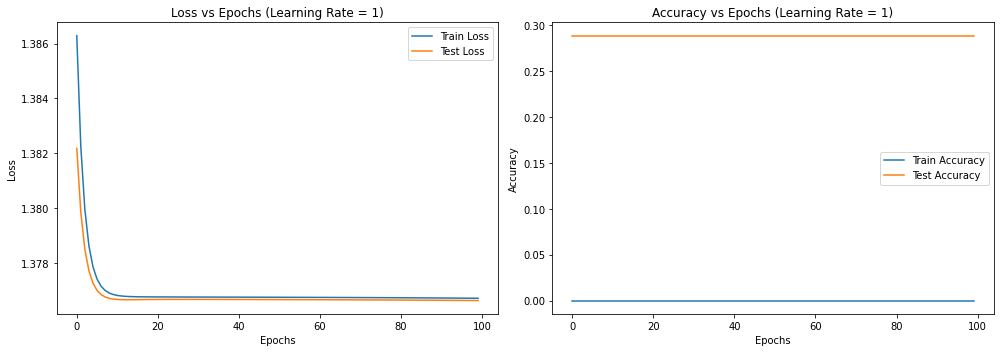

Training with learning rate 0.1
Epoch 10 | Train Loss: 1.3829 | Test Loss: 1.3826 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 20 | Train Loss: 1.3805 | Test Loss: 1.3803 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 30 | Train Loss: 1.3791 | Test Loss: 1.3789 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 40 | Train Loss: 1.3782 | Test Loss: 1.3780 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 50 | Train Loss: 1.3777 | Test Loss: 1.3775 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 60 | Train Loss: 1.3773 | Test Loss: 1.3772 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 70 | Train Loss: 1.3771 | Test Loss: 1.3770 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 80 | Train Loss: 1.3770 | Test Loss: 1.3768 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 90 | Train Loss: 1.3769 | Test Loss: 1.3768 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 100 | Train Loss: 1.3769 | Test Loss: 1.3767 | Train Acc: 0.0000 | Test Acc: 0.2888


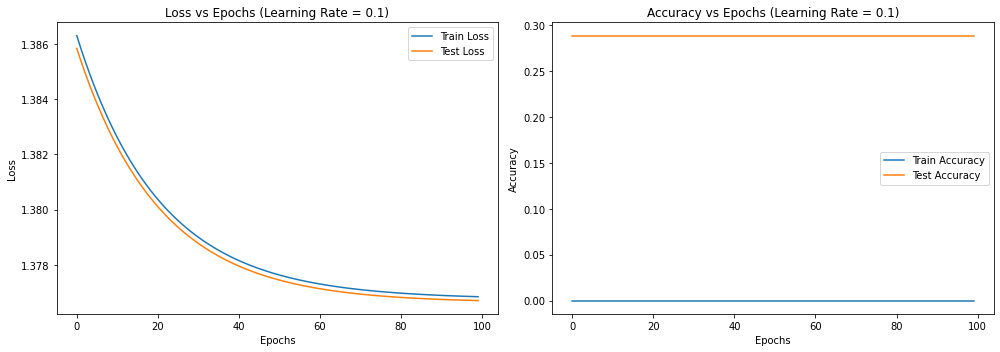

Training with learning rate 0.001
Epoch 10 | Train Loss: 1.3863 | Test Loss: 1.3862 | Train Acc: 0.0000 | Test Acc: 0.2897
Epoch 20 | Train Loss: 1.3862 | Test Loss: 1.3862 | Train Acc: 0.0000 | Test Acc: 0.2885
Epoch 30 | Train Loss: 1.3862 | Test Loss: 1.3862 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 40 | Train Loss: 1.3861 | Test Loss: 1.3861 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 50 | Train Loss: 1.3861 | Test Loss: 1.3861 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 60 | Train Loss: 1.3860 | Test Loss: 1.3860 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 70 | Train Loss: 1.3860 | Test Loss: 1.3860 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 80 | Train Loss: 1.3859 | Test Loss: 1.3859 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 90 | Train Loss: 1.3859 | Test Loss: 1.3859 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 100 | Train Loss: 1.3858 | Test Loss: 1.3858 | Train Acc: 0.0000 | Test Acc: 0.2888


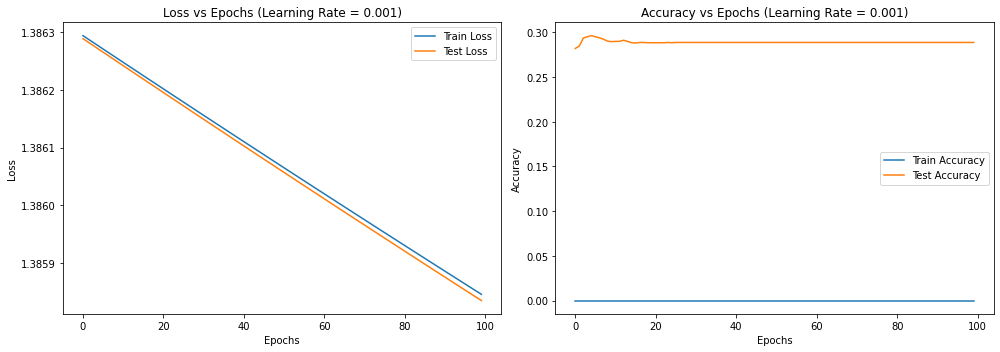

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Derivative of ReLU activation function
def relu_derivative(x):
    return (x > 0).astype(float)

# Softmax function with numerical stability
def softmax(x):
    shift_x = x - np.max(x, axis=1, keepdims=True)  # Subtract max for stability
    exp_x = np.exp(shift_x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Cross-entropy loss function with one-hot encoded labels and softmax output
def cross_entropy_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred = np.clip(y_pred, a_min=1e-10, a_max=None)  # Clip values to avoid log(0)
    loss = -np.sum(y_true * np.log(y_pred)) / n_samples
    return loss

# Function to compute accuracy
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == y_pred)

# One-hot encoding function
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y.reshape(-1)]

# Backpropagation and weight update with gradient clipping
def backprop(X, y, z1, a1, z2, a2, z3, output, W1, b1, W2, b2, W3, b3, learning_rate, clip_value=5.0):
    m = y.shape[0]
    output -= y  # Output is softmax - y_true for cross-entropy derivative
    output /= m

    dW3 = np.dot(a2.T, output)
    db3 = np.sum(output, axis=0, keepdims=True)

    da2 = np.dot(output, W3.T)
    dz2 = da2 * relu_derivative(z2)  # ReLU derivative

    dW2 = np.dot(a1.T, dz2)
    db2 = np.sum(dz2, axis=0, keepdims=True)

    da1 = np.dot(dz2, W2.T)
    dz1 = da1 * relu_derivative(z1)  # ReLU derivative

    dW1 = np.dot(X.T, dz1)
    db1 = np.sum(dz1, axis=0, keepdims=True)

    # Gradient clipping to avoid exploding gradients
    dW1 = np.clip(dW1, -clip_value, clip_value)
    dW2 = np.clip(dW2, -clip_value, clip_value)
    dW3 = np.clip(dW3, -clip_value, clip_value)
    db1 = np.clip(db1, -clip_value, clip_value)
    db2 = np.clip(db2, -clip_value, clip_value)
    db3 = np.clip(db3, -clip_value, clip_value)

    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3

    return W1, b1, W2, b2, W3, b3

# Forward propagation function
def forward_propagation(X, W1, b1, W2, b2, W3, b3):
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)  # ReLU activation

    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)  # ReLU activation

    z3 = np.dot(a2, W3) + b3
    output = softmax(z3)  # Softmax activation

    return z1, a1, z2, a2, z3, output

# Train the neural network
def train_neural_network(X_train, y_train, X_test, y_test, learning_rate, epochs, num_classes):
    input_size = X_train.shape[1]
    hidden_size1 = 100
    hidden_size2 = 40
    output_size = num_classes  # Number of classes

    # Initialize weights and biases with small random values
    np.random.seed(42)
    W1 = np.random.randn(input_size, hidden_size1) * 0.01
    b1 = np.zeros((1, hidden_size1))
    W2 = np.random.randn(hidden_size1, hidden_size2) * 0.01
    b2 = np.zeros((1, hidden_size2))
    W3 = np.random.randn(hidden_size2, output_size) * 0.01
    b3 = np.zeros((1, output_size))

    train_costs = []
    test_costs = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        # Forward propagation on training data
        z1, a1, z2, a2, z3, train_output = forward_propagation(X_train, W1, b1, W2, b2, W3, b3)

        # Calculate loss for training data
        train_loss = cross_entropy_loss(y_train, train_output)

        # Backpropagation and weight updates
        W1, b1, W2, b2, W3, b3 = backprop(X_train, y_train, z1, a1, z2, a2, z3, train_output, W1, b1, W2, b2, W3, b3, learning_rate)

        # Forward propagation on test data
        z1_test, a1_test, z2_test, a2_test, z3_test, test_output = forward_propagation(X_test, W1, b1, W2, b2, W3, b3)

        # Calculate loss and accuracy for test data
        test_loss = cross_entropy_loss(y_test, test_output)
        train_acc = accuracy(y_train, np.argmax(train_output, axis=1))
        test_acc = accuracy(y_test, np.argmax(test_output, axis=1))

        # Store loss and accuracy values
        train_costs.append(train_loss)
        test_costs.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

    return train_costs, test_costs, train_accs, test_accs

# Plot training results
def plot_metrics(train_costs, test_costs, train_accs, test_accs, learning_rate):
    epochs = len(train_costs)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_costs, label='Train Loss')
    plt.plot(range(epochs), test_costs, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss vs Epochs (Learning Rate = {learning_rate})')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accs, label='Train Accuracy')
    plt.plot(range(epochs), test_accs, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Epochs (Learning Rate = {learning_rate})')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Loading the data and performing one-hot encoding for labels
X_train = pd.read_csv(r"Task_2\x_train.csv").values  # features
y_train_raw = pd.read_csv(r"Task_2\y_train.csv").values  # raw labels

X_test = pd.read_csv(r"Task_2\x_test.csv").values
y_test_raw = pd.read_csv(r"Task_2\y_test.csv").values

# One-hot encode the labels
num_classes = 4  # Adjust based on your data
y_train = one_hot_encode(y_train_raw, num_classes)
y_test = one_hot_encode(y_test_raw, num_classes)

# Define learning rates and number of epochs
learning_rates = [1, 0.1, 0.001]
epochs = 100

for lr in learning_rates:
    print(f"Training with learning rate {lr}")
    train_costs, test_costs, train_accs, test_accs = train_neural_network(X_train, y_train, X_test, y_test, lr, epochs, num_classes)
    plot_metrics(train_costs, test_costs, train_accs, test_accs, lr)


(13106, 14) (13106, 4) (3276, 14) (3276, 4)
Training with learning rate 1
Epoch 10 | Train Loss: 16.5202 | Test Loss: 3.8764 | Train Acc: 0.0 | Test Acc: 0.2024
Epoch 20 | Train Loss: 1.3863 | Test Loss: 5.0277 | Train Acc: 0.0 | Test Acc: 0.2888
Epoch 30 | Train Loss: 1.3863 | Test Loss: 5.0277 | Train Acc: 0.0 | Test Acc: 0.2888
Epoch 40 | Train Loss: 1.3863 | Test Loss: 5.0277 | Train Acc: 0.0 | Test Acc: 0.2888
Epoch 50 | Train Loss: 1.3863 | Test Loss: 5.0277 | Train Acc: 0.0 | Test Acc: 0.2888


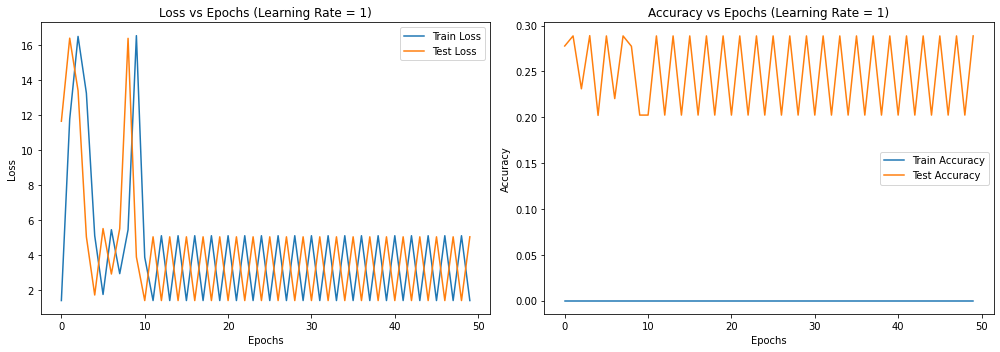

Training with learning rate 0.1
Epoch 10 | Train Loss: 1.4461 | Test Loss: 1.3863 | Train Acc: 0.0 | Test Acc: 0.2024
Epoch 20 | Train Loss: 1.4461 | Test Loss: 1.3863 | Train Acc: 0.0 | Test Acc: 0.2024
Epoch 30 | Train Loss: 1.4461 | Test Loss: 1.3863 | Train Acc: 0.0 | Test Acc: 0.2024
Epoch 40 | Train Loss: 1.4461 | Test Loss: 1.3863 | Train Acc: 0.0 | Test Acc: 0.2024
Epoch 50 | Train Loss: 1.4461 | Test Loss: 1.3863 | Train Acc: 0.0 | Test Acc: 0.2024


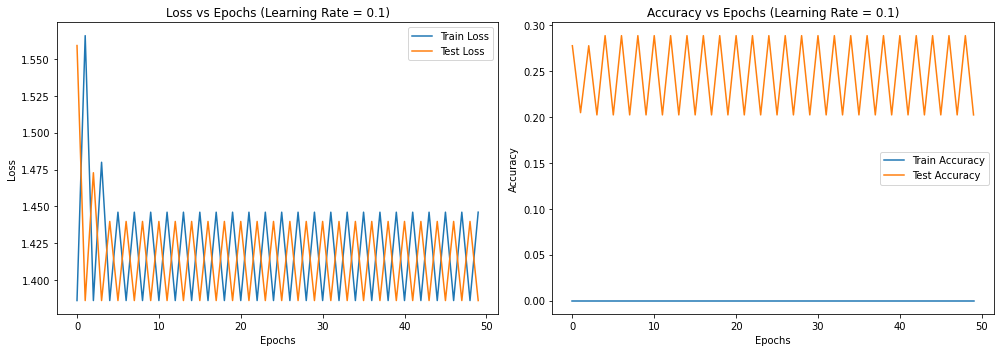

Training with learning rate 0.001
Epoch 10 | Train Loss: 1.3791 | Test Loss: 1.3779 | Train Acc: 0.0 | Test Acc: 0.2888
Epoch 20 | Train Loss: 1.3524 | Test Loss: 1.3434 | Train Acc: 0.0 | Test Acc: 0.3394
Epoch 30 | Train Loss: 1.1836 | Test Loss: 1.1706 | Train Acc: 0.0 | Test Acc: 0.3587
Epoch 40 | Train Loss: 1.0975 | Test Loss: 1.0751 | Train Acc: 0.0 | Test Acc: 0.4164
Epoch 50 | Train Loss: 1.0410 | Test Loss: 1.0021 | Train Acc: 0.0 | Test Acc: 0.5562


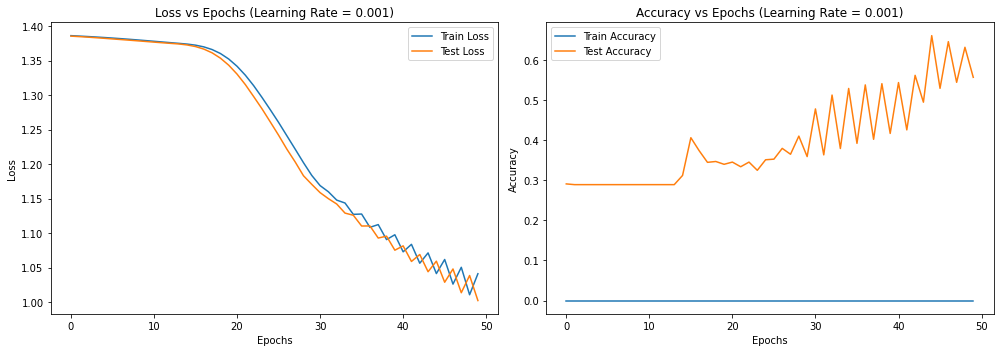

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class NeuralNetwork:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, learning_rate, clip_value=5.0):
        # Initialize weights and biases
        np.random.seed(42)
        self.W1 = np.random.randn(input_size, hidden_size1) * 0.01
        self.b1 = np.zeros((1, hidden_size1))
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * 0.01
        self.b2 = np.zeros((1, hidden_size2))
        self.W3 = np.random.randn(hidden_size2, output_size) * 0.01
        self.b3 = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.clip_value = clip_value
    
    # ReLU activation function
    def relu(self, x):
        return np.maximum(0, x)
    
    # Derivative of ReLU activation function
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    # Softmax function with numerical stability
    def softmax(self, x):
        shift_x = x - np.max(x, axis=1, keepdims=True)  # Subtract max for stability
        exp_x = np.exp(shift_x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    # Cross-entropy loss function with one-hot encoded labels and softmax output
    def cross_entropy_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]
        y_pred = np.clip(y_pred, a_min=1e-10, a_max=None)  # Clip values to avoid log(0)
        loss = -np.sum(y_true * np.log(y_pred)) / n_samples
        return loss

    # Function to compute accuracy
    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    # One-hot encoding function
    @staticmethod
    def one_hot_encode(y, num_classes):
        return np.eye(num_classes)[y.reshape(-1)]
    
    # Forward propagation function
    def forward_propagation(self, X):
        z1 = np.dot(X, self.W1) + self.b1
        a1 = self.relu(z1)

        z2 = np.dot(a1, self.W2) + self.b2
        a2 = self.relu(z2)

        z3 = np.dot(a2, self.W3) + self.b3
        output = self.softmax(z3)

        return z1, a1, z2, a2, z3, output
    
    # Backpropagation and weight update
    def backprop(self, X, y, z1, a1, z2, a2, z3, output):
        m = y.shape[0]
        output -= y  # Output is softmax - y_true for cross-entropy derivative
        output /= m

        # Gradients for W3 and b3
        dW3 = np.dot(a2.T, output)
        db3 = np.sum(output, axis=0, keepdims=True)

        # Gradients for W2 and b2
        da2 = np.dot(output, self.W3.T)
        dz2 = da2 * self.relu_derivative(a2)

        dW2 = np.dot(a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        # Gradients for W1 and b1
        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * self.relu_derivative(a1)

        dW1 = np.dot(X.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        # Gradient clipping to avoid exploding gradients
        dW1 = np.clip(dW1, -self.clip_value, self.clip_value)
        dW2 = np.clip(dW2, -self.clip_value, self.clip_value)
        dW3 = np.clip(dW3, -self.clip_value, self.clip_value)
        db1 = np.clip(db1, -self.clip_value, self.clip_value)
        db2 = np.clip(db2, -self.clip_value, self.clip_value)
        db3 = np.clip(db3, -self.clip_value, self.clip_value)


        # Update weights and biases
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3
    
    # Train the neural network
    def train(self, X_train, y_train, X_test, y_test, epochs):
        train_costs = []
        test_costs = []
        train_accs = []
        test_accs = []

        for epoch in range(epochs):
            # Forward propagation on training data
            z1, a1, z2, a2, z3, train_output = self.forward_propagation(X_train)

            # print(train_output.shape)

            # Calculate loss for training data
            train_loss = self.cross_entropy_loss(y_train, train_output)

            # Backpropagation and weight updates
            self.backprop(X_train, y_train, z1, a1, z2, a2, z3, train_output)

            # Forward propagation on test data
            z1_test, a1_test, z2_test, a2_test, z3_test, test_output = self.forward_propagation(X_test)

            # Calculate loss and accuracy for test data
            test_loss = self.cross_entropy_loss(y_test, test_output)
            train_acc = self.accuracy(np.argmax(y_train, axis=1), np.argmax(train_output, axis=1))
            test_acc = self.accuracy(np.argmax(y_test, axis=1), np.argmax(test_output, axis=1))

            # Store loss and accuracy values
            train_costs.append(train_loss)
            test_costs.append(test_loss)
            train_accs.append(train_acc)
            test_accs.append(test_acc)

            # Print progress every 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

        return train_costs, test_costs, train_accs, test_accs
    
    # Plot training results
    def plot_metrics(self, train_costs, test_costs, train_accs, test_accs):
        epochs = len(train_costs)
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        plt.plot(range(epochs), train_costs, label='Train Loss')
        plt.plot(range(epochs), test_costs, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Loss vs Epochs (Learning Rate = {self.learning_rate})')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(epochs), train_accs, label='Train Accuracy')
        plt.plot(range(epochs), test_accs, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy vs Epochs (Learning Rate = {self.learning_rate})')
        plt.legend()

        plt.tight_layout()
        plt.show()


# Loading the data and performing one-hot encoding for labels
X_train = pd.read_csv(r"Task_2\x_train.csv").values  # Features
y_train_raw = pd.read_csv(r"Task_2\y_train.csv").values  # Raw labels

X_test = pd.read_csv(r"Task_2\x_test.csv").values
y_test_raw = pd.read_csv(r"Task_2\y_test.csv").values

# One-hot encode the labels
num_classes = 4  # Adjust based on your data
y_train = NeuralNetwork.one_hot_encode(y_train_raw, num_classes)
y_test = NeuralNetwork.one_hot_encode(y_test_raw, num_classes)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Define hyperparameters
input_size = X_train.shape[1]
hidden_size1 = 100
hidden_size2 = 40
output_size = num_classes  # Number of classes
learning_rates = [1, 0.1, 0.001]
epochs = 50

# # Train neural networks for different learning rates
for lr in learning_rates:
    print(f"Training with learning rate {lr}")
    nn = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size, learning_rate=lr)
    train_costs, test_costs, train_accs, test_accs = nn.train(X_train, y_train, X_test, y_test, epochs)
    nn.plot_metrics(train_costs, test_costs, train_accs, test_accs)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class NeuralNetwork:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, learning_rate, clip_value=5.0):
        np.random.seed(42)
        # Xavier initialization for layers with ReLU activations
        self.W1 = np.random.randn(input_size, hidden_size1) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size1))
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * np.sqrt(2.0 / hidden_size1)
        self.b2 = np.zeros((1, hidden_size2))
        self.W3 = np.random.randn(hidden_size2, output_size) * np.sqrt(1.0 / hidden_size2)  # Softmax doesn't need large initialization
        self.b3 = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.clip_value = clip_value

    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def softmax(self, x):
        shift_x = x - np.max(x, axis=1, keepdims=True)  # Subtract max for stability
        exp_x = np.exp(shift_x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]
        y_pred = np.clip(y_pred, a_min=1e-10, a_max=None)
        loss = -np.sum(y_true * np.log(y_pred)) / n_samples
        return loss

    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    @staticmethod
    def one_hot_encode(y, num_classes):
        return np.eye(num_classes)[y.reshape(-1)]
    
    def forward_propagation(self, X):
        z1 = np.dot(X, self.W1) + self.b1
        a1 = self.relu(z1)

        z2 = np.dot(a1, self.W2) + self.b2
        a2 = self.relu(z2)

        z3 = np.dot(a2, self.W3) + self.b3
        output = self.softmax(z3)

        return z1, a1, z2, a2, z3, output
    
    def backprop(self, X, y, z1, a1, z2, a2, z3, output):
        m = y.shape[0]
        output -= y
        output /= m

        dW3 = np.dot(a2.T, output)
        db3 = np.sum(output, axis=0, keepdims=True)

        da2 = np.dot(output, self.W3.T)
        dz2 = da2 * self.relu_derivative(a2)

        dW2 = np.dot(a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * self.relu_derivative(a1)

        dW1 = np.dot(X.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        dW1 = np.clip(dW1, -self.clip_value, self.clip_value)
        dW2 = np.clip(dW2, -self.clip_value, self.clip_value)
        dW3 = np.clip(dW3, -self.clip_value, self.clip_value)
        db1 = np.clip(db1, -self.clip_value, self.clip_value)
        db2 = np.clip(db2, -self.clip_value, self.clip_value)
        db3 = np.clip(db3, -self.clip_value, self.clip_value)

        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3
    
    def train(self, X_train, y_train, X_test, y_test, epochs):
        train_costs = []
        test_costs = []
        train_accs = []
        test_accs = []

        for epoch in range(epochs):
            z1, a1, z2, a2, z3, train_output = self.forward_propagation(X_train)
            train_loss = self.cross_entropy_loss(y_train, train_output)

            self.backprop(X_train, y_train, z1, a1, z2, a2, z3, train_output)

            z1_test, a1_test, z2_test, a2_test, z3_test, test_output = self.forward_propagation(X_test)
            test_loss = self.cross_entropy_loss(y_test, test_output)
            train_acc = self.accuracy(np.argmax(y_train, axis=1), np.argmax(train_output, axis=1))
            test_acc = self.accuracy(np.argmax(y_test, axis=1), np.argmax(test_output, axis=1))

            train_costs.append(train_loss)
            test_costs.append(test_loss)
            train_accs.append(train_acc)
            test_accs.append(test_acc)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

        return train_costs, test_costs, train_accs, test_accs
    
    def plot_metrics(self, train_costs, test_costs, train_accs, test_accs):
        epochs = len(train_costs)
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        plt.plot(range(epochs), train_costs, label='Train Loss')
        plt.plot(range(epochs), test_costs, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Loss vs Epochs (Learning Rate = {self.learning_rate})')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(epochs), train_accs, label='Train Accuracy')
        plt.plot(range(epochs), test_accs, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy vs Epochs (Learning Rate = {self.learning_rate})')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Load data, perform one-hot encoding, train and plot metrics (same as before)


(13106, 14) (13106, 4) (3276, 14) (3276, 4)
Training with learning rate 1
Epoch 10 | Train Loss: 16.4762 | Test Loss: 16.6298 | Train Acc: 0.0000 | Test Acc: 0.2778
Epoch 20 | Train Loss: 17.4600 | Test Loss: 16.3767 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 30 | Train Loss: 18.4667 | Test Loss: 16.3767 | Train Acc: 0.1980 | Test Acc: 0.2888
Epoch 40 | Train Loss: 16.6747 | Test Loss: 17.7052 | Train Acc: 0.0000 | Test Acc: 0.2311
Epoch 50 | Train Loss: 18.4667 | Test Loss: 16.6298 | Train Acc: 0.1980 | Test Acc: 0.2778
Epoch 60 | Train Loss: 18.4667 | Test Loss: 16.6298 | Train Acc: 0.1980 | Test Acc: 0.2778
Epoch 70 | Train Loss: 17.4600 | Test Loss: 16.3767 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 80 | Train Loss: 18.4667 | Test Loss: 16.3767 | Train Acc: 0.1980 | Test Acc: 0.2888
Epoch 90 | Train Loss: 16.6747 | Test Loss: 17.7052 | Train Acc: 0.0000 | Test Acc: 0.2311
Epoch 100 | Train Loss: 18.4667 | Test Loss: 16.6298 | Train Acc: 0.1980 | Test Acc: 0.2778
Epoch 110 | Tra

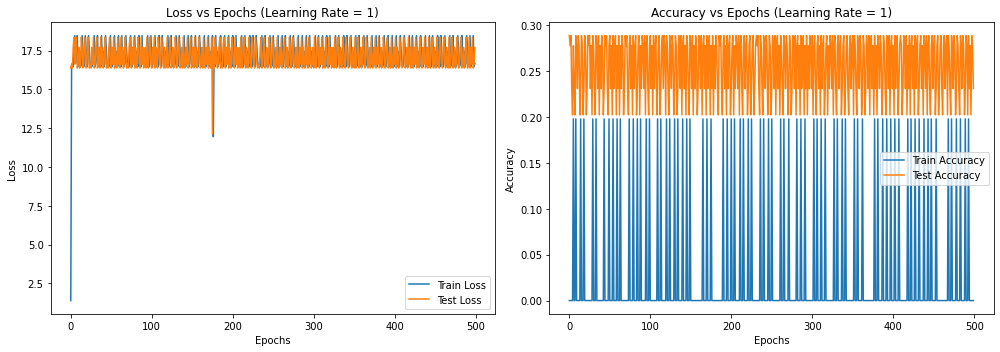

Training with learning rate 0.1
Epoch 10 | Train Loss: 16.6747 | Test Loss: 16.3767 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 20 | Train Loss: 17.4600 | Test Loss: 16.3767 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 30 | Train Loss: 16.6747 | Test Loss: 16.3767 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 40 | Train Loss: 16.6747 | Test Loss: 17.7052 | Train Acc: 0.0000 | Test Acc: 0.2311
Epoch 50 | Train Loss: 16.4762 | Test Loss: 16.6298 | Train Acc: 0.0000 | Test Acc: 0.2778
Epoch 60 | Train Loss: 16.4762 | Test Loss: 17.7052 | Train Acc: 0.0000 | Test Acc: 0.2311
Epoch 70 | Train Loss: 17.4600 | Test Loss: 16.3767 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 80 | Train Loss: 16.6747 | Test Loss: 16.3767 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 90 | Train Loss: 17.4600 | Test Loss: 16.6298 | Train Acc: 0.0000 | Test Acc: 0.2778
Epoch 100 | Train Loss: 18.4667 | Test Loss: 16.6298 | Train Acc: 0.0000 | Test Acc: 0.2778
Epoch 110 | Train Loss: 16.4762 | Test Loss: 17.7052 | Tr

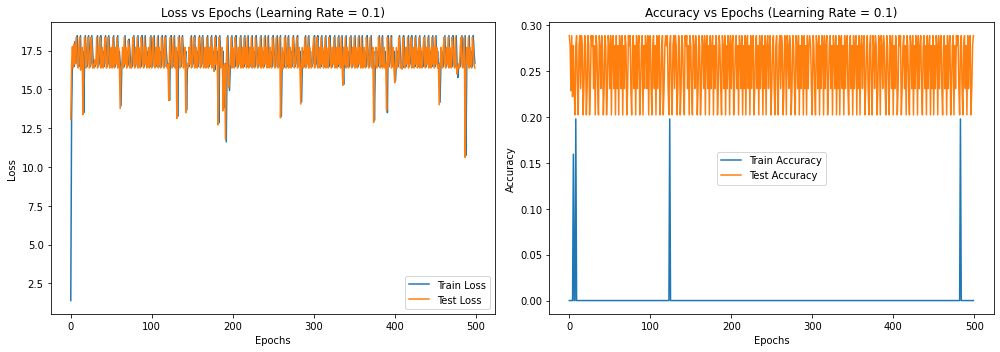

Training with learning rate 0.001
Epoch 10 | Train Loss: 2.5804 | Test Loss: 1.5138 | Train Acc: 0.0000 | Test Acc: 0.2024
Epoch 20 | Train Loss: 2.7008 | Test Loss: 2.6356 | Train Acc: 0.0000 | Test Acc: 0.2311
Epoch 30 | Train Loss: 2.9000 | Test Loss: 2.3559 | Train Acc: 0.0000 | Test Acc: 0.2024
Epoch 40 | Train Loss: 2.2867 | Test Loss: 2.0279 | Train Acc: 0.0000 | Test Acc: 0.2888
Epoch 50 | Train Loss: 2.5120 | Test Loss: 1.4971 | Train Acc: 0.0000 | Test Acc: 0.2024
Epoch 60 | Train Loss: 2.5825 | Test Loss: 2.5139 | Train Acc: 0.0000 | Test Acc: 0.2311
Epoch 70 | Train Loss: 2.3570 | Test Loss: 2.2531 | Train Acc: 0.0000 | Test Acc: 0.2311
Epoch 80 | Train Loss: 3.1379 | Test Loss: 2.3938 | Train Acc: 0.0000 | Test Acc: 0.2024
Epoch 90 | Train Loss: 2.4819 | Test Loss: 2.2064 | Train Acc: 0.0000 | Test Acc: 0.2311
Epoch 100 | Train Loss: 2.0724 | Test Loss: 2.6874 | Train Acc: 0.0000 | Test Acc: 0.2778
Epoch 110 | Train Loss: 2.3341 | Test Loss: 2.2145 | Train Acc: 0.0000 | Te

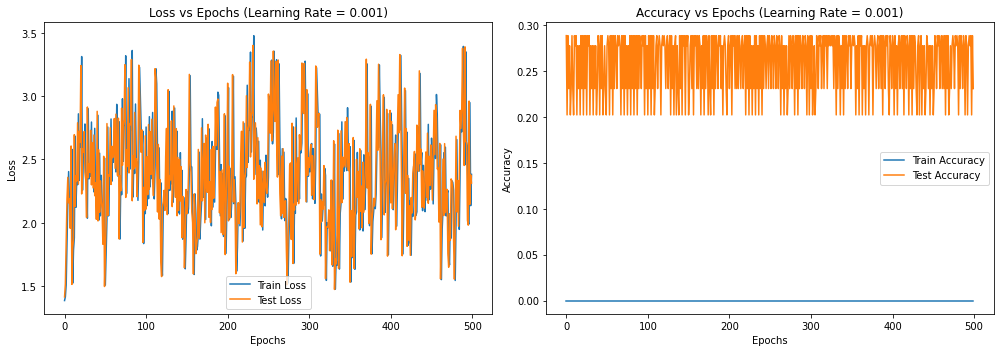

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class NeuralNetwork:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, learning_rate, clip_value=5.0):
        # Initialize weights and biases
        np.random.seed(42)
        self.W1 = np.random.randn(input_size, hidden_size1) * 0.01
        self.b1 = np.zeros((1, hidden_size1))
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * 0.01
        self.b2 = np.zeros((1, hidden_size2))
        self.W3 = np.random.randn(hidden_size2, output_size) * 0.01
        self.b3 = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.clip_value = clip_value
    
    # ReLU activation function
    def relu(self, x):
        return np.maximum(0, x)
    
    # Derivative of ReLU activation function
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    # Softmax function with numerical stability
    def softmax(self, x):
        shift_x = x - np.max(x, axis=1, keepdims=True)  # Subtract max for stability
        exp_x = np.exp(shift_x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    # Cross-entropy loss function with one-hot encoded labels and softmax output
    def cross_entropy_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]
        y_pred = np.clip(y_pred, a_min=1e-10, a_max=None)  # Clip values to avoid log(0)
        loss = -np.sum(y_true * np.log(y_pred)) / n_samples
        return loss

    # Function to compute accuracy
    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    # One-hot encoding function
    @staticmethod
    def one_hot_encode(y, num_classes):
        return np.eye(num_classes)[y.reshape(-1)]
    
    # Forward propagation function
    def forward_propagation(self, X):
        z1 = np.dot(X, self.W1) + self.b1
        a1 = self.relu(z1)

        z2 = np.dot(a1, self.W2) + self.b2
        a2 = self.relu(z2)

        z3 = np.dot(a2, self.W3) + self.b3
        output = self.softmax(z3)

        return z1, a1, z2, a2, z3, output
    
    # Backpropagation and weight update
    def backprop(self, X, y, z1, a1, z2, a2, z3, output):
        m = y.shape[0]
        output -= y  # Output is softmax - y_true for cross-entropy derivative
        # output /= m

        # Gradients for W3 and b3
        dW3 = np.dot(a2.T, output)
        db3 = np.sum(output, axis=0, keepdims=True)

        # Gradients for W2 and b2
        da2 = np.dot(output, self.W3.T)
        dz2 = da2 * self.relu_derivative(a2)

        dW2 = np.dot(a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        # Gradients for W1 and b1
        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * self.relu_derivative(a1)

        dW1 = np.dot(X.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        # Gradient clipping to avoid exploding gradients
        # dW1 = np.clip(dW1, -self.clip_value, self.clip_value)
        # dW2 = np.clip(dW2, -self.clip_value, self.clip_value)
        # dW3 = np.clip(dW3, -self.clip_value, self.clip_value)
        # db1 = np.clip(db1, -self.clip_value, self.clip_value)
        # db2 = np.clip(db2, -self.clip_value, self.clip_value)
        # db3 = np.clip(db3, -self.clip_value, self.clip_value)

        # Update weights and biases
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3
    
    # Train the neural network
    def train(self, X_train, y_train, X_test, y_test, epochs):
        train_costs = []
        test_costs = []
        train_accs = []
        test_accs = []

        for epoch in range(epochs):
            # Forward propagation on training data
            z1, a1, z2, a2, z3, train_output = self.forward_propagation(X_train)

            # Calculate loss for training data
            train_loss = self.cross_entropy_loss(y_train, train_output)

            # Backpropagation and weight updates
            self.backprop(X_train, y_train, z1, a1, z2, a2, z3, train_output)

            # Forward propagation on test data
            z1_test, a1_test, z2_test, a2_test, z3_test, test_output = self.forward_propagation(X_test)

            # Calculate loss and accuracy for test data
            test_loss = self.cross_entropy_loss(y_test, test_output)
            train_acc = self.accuracy(np.argmax(y_train, axis=1), np.argmax(train_output, axis=1))
            test_acc = self.accuracy(np.argmax(y_test, axis=1), np.argmax(test_output, axis=1))

            # Store loss and accuracy values
            train_costs.append(train_loss)
            test_costs.append(test_loss)
            train_accs.append(train_acc)
            test_accs.append(test_acc)

            # Print progress every 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

        return train_costs, test_costs, train_accs, test_accs
    
    # Plot training results
    def plot_metrics(self, train_costs, test_costs, train_accs, test_accs):
        epochs = len(train_costs)
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        plt.plot(range(epochs), train_costs, label='Train Loss')
        plt.plot(range(epochs), test_costs, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Loss vs Epochs (Learning Rate = {self.learning_rate})')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(epochs), train_accs, label='Train Accuracy')
        plt.plot(range(epochs), test_accs, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy vs Epochs (Learning Rate = {self.learning_rate})')
        plt.legend()

        plt.tight_layout()
        plt.show()


# Loading the data and performing one-hot encoding for labels
X_train = pd.read_csv(r"Task_2\x_train.csv").values  # Features
y_train_raw = pd.read_csv(r"Task_2\y_train.csv").values  # Raw labels

X_test = pd.read_csv(r"Task_2\x_test.csv").values
y_test_raw = pd.read_csv(r"Task_2\y_test.csv").values

# One-hot encode the labels
num_classes = 4  # Adjust based on your data
y_train = NeuralNetwork.one_hot_encode(y_train_raw, num_classes)
y_test = NeuralNetwork.one_hot_encode(y_test_raw, num_classes)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Define hyperparameters
input_size = X_train.shape[1]
hidden_size1 = 100
hidden_size2 = 40
output_size = num_classes  # Number of classes
learning_rates = [1, 0.1, 0.001]
epochs = 500

# Train neural networks for different learning rates
for lr in learning_rates:
    print(f"Training with learning rate {lr}")
    nn = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size, learning_rate=lr)
    train_costs, test_costs, train_accs, test_accs = nn.train(X_train, y_train, X_test, y_test, epochs)
    nn.plot_metrics(train_costs, test_costs, train_accs, test_accs)
